# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация.

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**:

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей.

Сгенерируем синтетические данные.

In [25]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [26]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, make_scorer, precision_recall_curve

def pr(y_true, y_pred):
  pr, recall, _ = precision_recall_curve(y_true, y_pred)
  return auc(recall, pr)

auc_pr = make_scorer(pr)

params = {"C": np.linspace(1e-4, 1, 20)}

model = LinearSVC(max_iter=200000)
searcher = GridSearchCV(model, params)
searcher.fit(X_train, y_train)
searcher.best_params_, searcher.best_score_

({'C': 0.05272631578947369}, 0.7794285714285714)

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

AUC-PR: f{5} 0.8296805289493085
AUC-ROC: f{5} 0.8476470977827819


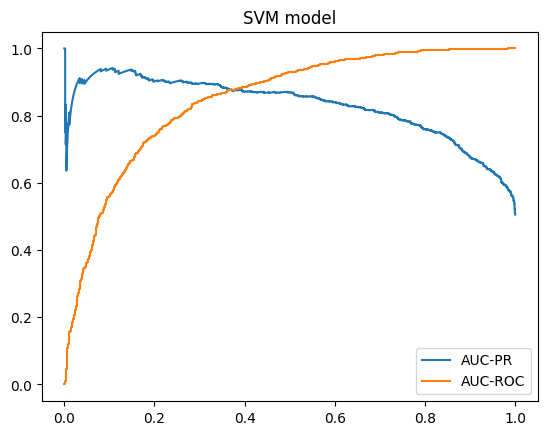

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

best_model = LinearSVC(C=0.05273, max_iter=200000)
best_model.fit(X_train, y_train)
y_preds = best_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_preds)
precision, recall, _ = precision_recall_curve(y_test, y_preds)

plt.plot(recall, precision)
plt.plot(fpr, tpr)
plt.legend(["AUC-PR", "AUC-ROC"])
plt.title("SVM model")
print("AUC-PR: f{5}", pr(y_test, y_preds))
print("AUC-ROC: f{5}", roc_auc_score(y_test, y_preds))

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

best params: {'C': 0.10535263157894738}
AUC-PR: f{5} 0.8291658803497801
AUC-ROC: f{5} 0.8478502349857381


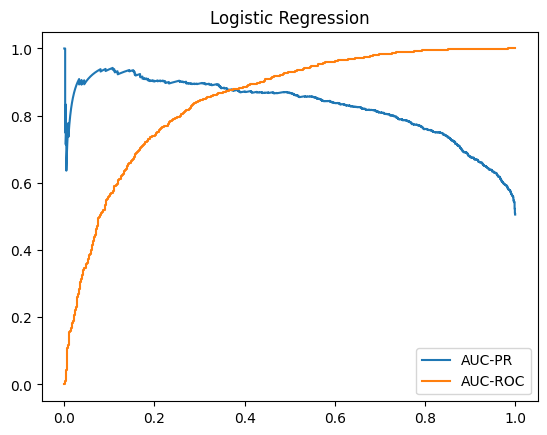

In [28]:
from sklearn.linear_model import LogisticRegression

params = {"C": np.linspace(1e-4, 1, 20)}

model = LogisticRegression(max_iter=200000)
searcher = GridSearchCV(model, params)
searcher.fit(X_train, y_train)
print("best params:",searcher.best_params_)
best_model = LogisticRegression(C=searcher.best_params_["C"], max_iter=200000)
best_model.fit(X_train, y_train)
y_preds = [pred[1] for pred in best_model.predict_proba(X_test)]
fpr, tpr, _ = roc_curve(y_test, y_preds)
precision, recall, _ = precision_recall_curve(y_test, y_preds)
plt.plot(recall, precision)
plt.plot(fpr, tpr)
plt.legend(["AUC-PR", "AUC-ROC"])
plt.title("Logistic Regression")
print("AUC-PR: f{5}", pr(y_test, y_preds))
print("AUC-ROC: f{5}", roc_auc_score(y_test, y_preds))

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

count of support_vectors:  2923


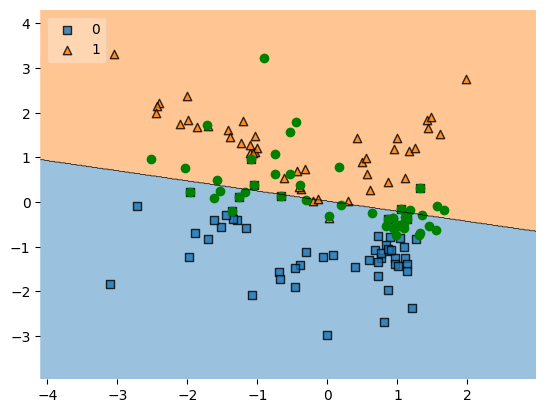

In [29]:
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

model = SVC(kernel='linear')
model.fit(X, y)
plot_decision_regions(X[:100], y[:100], model, legend=2)
print("count of support_vectors: ", len(model.support_vectors_))
x_vec = [p[0] for p in model.support_vectors_[:50]]
y_vec = [p[1] for p in model.support_vectors_[:50]]
plt.scatter(x_vec, y_vec, color="green")

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [30]:
#your code here

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [31]:
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.title(label)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

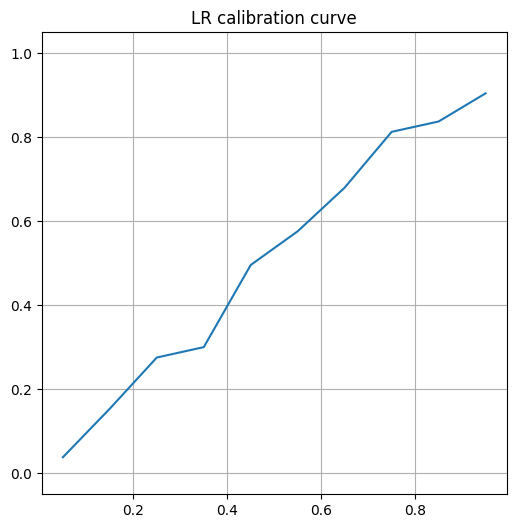

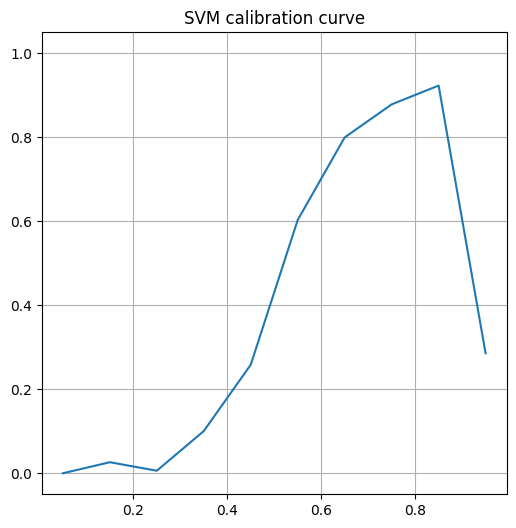

In [32]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

lr = LogisticRegression()
svm = SVC(kernel='linear')

lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
svm_preds = svm.decision_function(X_test)
svm_preds = (svm_preds - svm_preds.min()) / (svm_preds.max() - svm_preds.min())
lr_preds = np.array([pred[1] for pred in lr.predict_proba(X_test)])

plot_calibration_curve(y_test, lr_preds, "LR calibration curve")
plot_calibration_curve(y_test, svm_preds, "SVM calibration curve")

Если преобразовывать выходы метода опорных векторов с помощью сигмоиды, но калибровочная кривая получится лучше, так как сигмоида частный случай калибровки Платта.

(array([111., 129., 134., 108., 102., 100.,  84.,  90., 105.,  96.,  91.,
         96.,  78.,  77.,  90.,  90., 103.,  78.,  74.,  98.,  70., 101.,
         86., 105., 124., 114., 118., 137., 133.,  78.]),
 array([0.00219807, 0.03535218, 0.0685063 , 0.10166041, 0.13481453,
        0.16796864, 0.20112276, 0.23427688, 0.26743099, 0.30058511,
        0.33373922, 0.36689334, 0.40004745, 0.43320157, 0.46635568,
        0.4995098 , 0.53266392, 0.56581803, 0.59897215, 0.63212626,
        0.66528038, 0.69843449, 0.73158861, 0.76474272, 0.79789684,
        0.83105096, 0.86420507, 0.89735919, 0.9305133 , 0.96366742,
        0.99682153]),
 <BarContainer object of 30 artists>)

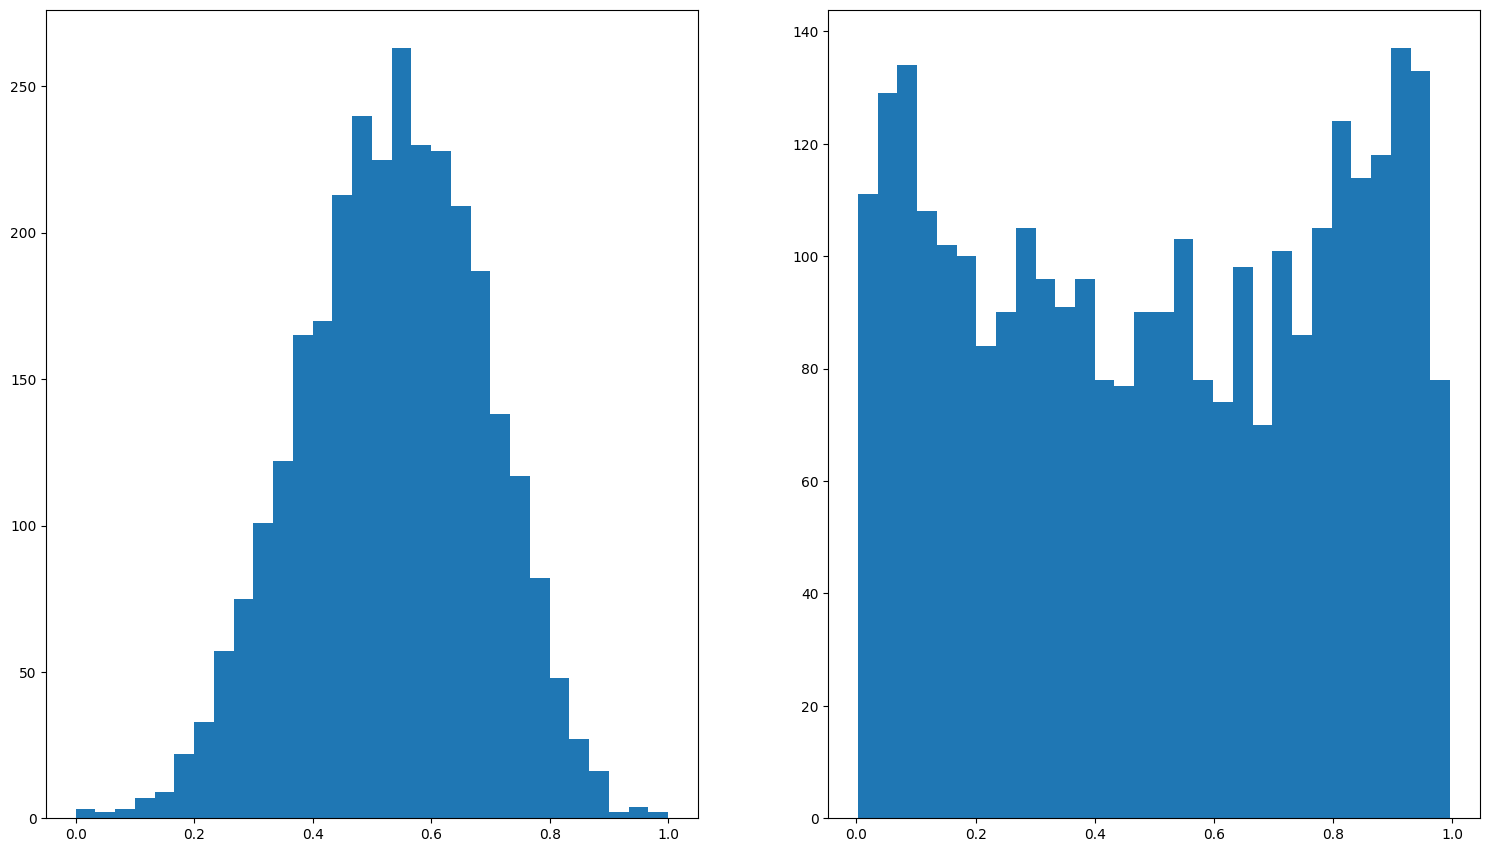

In [33]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax[0].hist(svm_preds, bins=30)
ax[1].hist(lr_preds, bins=30)

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

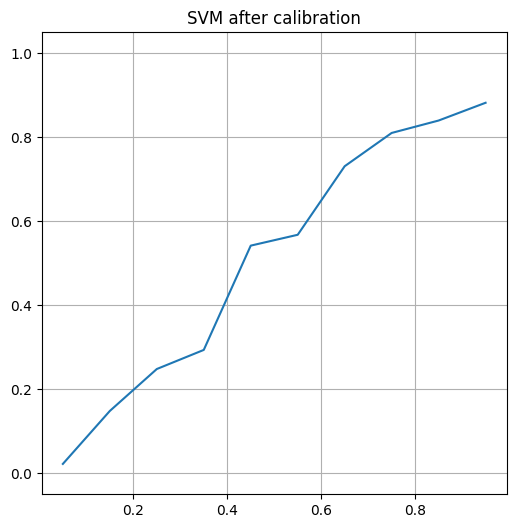

In [34]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(svm)
calibrator.fit(X_train, y_train)

probs = np.array([prob[1] for prob in calibrator.predict_proba(X_test)])
plot_calibration_curve(y_test, probs, "SVM after calibration")

Видно, что после калибровки вероятностей модель значительно лучше стала предсказывать вероятности

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [35]:
class PlattCalibrationClassifier:
  def __init__(self, estimator):
    self.estimator_ = estimator

  def fit(self, X_train, y_train):
    n_samples = X_train.shape[0]
    decisions = np.reshape(self.estimator_.decision_function(X_train), (n_samples, 1))
    model = LogisticRegression().fit(decisions, y_train)
    self.calibrated_classifier_ = model

  def predict_proba(self, X_test):
    n_samples = X_test.shape[0]
    decisions = np.reshape(self.estimator_.decision_function(X_test), (n_samples, 1))
    return self.calibrated_classifier_.predict_proba(decisions)

  def predict(self, X_test):
    n_samples = X_test.shape[0]
    decisions = np.reshape(self.estimator_.decision_function(X_test) (n_samples, 1))
    return self.calibrated_classifier_.predict(decisions)

Провёдем калибровку метода опорных векторов с помощью калибровки Платта

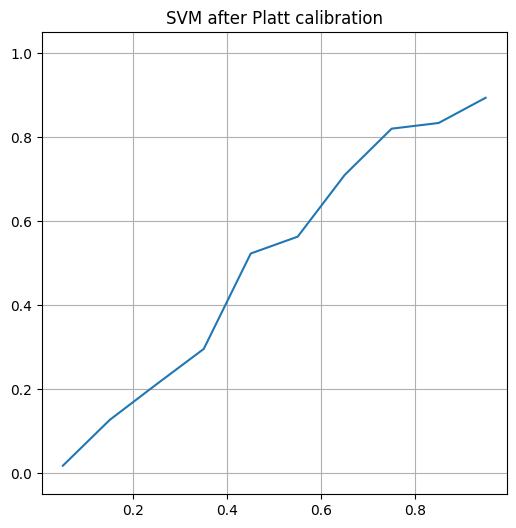

In [36]:
calibrator = PlattCalibrationClassifier(svm)

X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, train_size=0.3)

calibrator.fit(X_test1, y_test1)

probs = np.array([prob[1] for prob in calibrator.predict_proba(X_test2)])
plot_calibration_curve(y_test2, probs, "SVM after Platt calibration")

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [37]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-12-05 18:55:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [   <=>              ] 434.15K   673KB/s    in 0.6s    

2023-12-05 18:55:33 (673 KB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [38]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
10109,35,housemaid,married,high.school,no,no,no,telephone,jun,thu,56,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1,no
32319,54,technician,married,university.degree,unknown,no,no,cellular,may,fri,56,5,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
12050,26,admin.,married,high.school,no,no,no,telephone,jun,fri,120,6,999,0,nonexistent,1.4,94.465,-41.8,4.947,5228.1,no
21379,33,admin.,single,university.degree,no,yes,no,cellular,aug,tue,99,6,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
6816,44,blue-collar,single,basic.4y,unknown,no,no,telephone,may,wed,189,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
29808,29,technician,single,basic.9y,no,yes,no,cellular,apr,mon,114,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,yes
1598,34,self-employed,married,professional.course,no,unknown,unknown,telephone,may,fri,252,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
8134,39,entrepreneur,married,high.school,no,no,no,telephone,jun,mon,232,3,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
34952,56,services,married,high.school,unknown,no,no,cellular,may,fri,217,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
30533,41,admin.,single,high.school,no,yes,no,cellular,may,mon,306,3,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no


In [39]:
df["nr.employed"].value_counts()

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его.



Столбец о количестве сотрудников не несёт никакой информации для решения нашей задачи.

In [40]:
y = df["y"]
X = df.drop(columns=["nr.employed", "y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [41]:
y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: в данной задаче мы имеем дело с несбалансированным датасетом, где количество объектов с меткой "no" 36к против 4к с меткой "yes". В таком случае AUC-ROC может выдавать неккоректные оценки модели, в то время как AUC-PR справляется с проблемой несбалансированности классов.

In [42]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

encoder = OrdinalEncoder()
scaler = StandardScaler()
X_numeric = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"]
X_categorical = list(set(X.columns) - set(X_numeric))
encoded_train = encoder.fit_transform(X_train[X_categorical])
encoded_test = encoder.transform(X_test[X_categorical])
y_train = [0 if x == "no" else 1 for x in y_train]
y_test = [0 if x == "no" else 1 for x in y_test]

scaled_train = scaler.fit_transform(X_train[X_numeric])
scaled_test = scaler.transform(X_test[X_numeric])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

print("count of features: ", X_train_prep.shape[1])
model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

count of features:  19
AUC-PR:  0.5641236095313655


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [43]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

encoded_train = encoder.fit_transform(X_train[X_categorical])
encoded_test = encoder.transform(X_test[X_categorical])

scaled_train = scaler.fit_transform(X_train[X_numeric])
scaled_test = scaler.transform(X_test[X_numeric])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

print("count of features: ", X_train_prep.shape[1])
model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


count of features:  62
AUC-PR:  0.5752627649725752


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.


In [49]:
from matplotlib.patches import NonIntersectingPathException
from sklearn.base import BaseEstimator, TransformerMixin
from numpy.random import normal
from sklearn.model_selection import KFold

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, noise=False, noise_value=None, smoothing=False, strategy=None, C=10, fold_count=None):
    self.noise_ = noise
    self.fold_count_ = fold_count
    self.smoothing_ = smoothing
    self.noise_value_ = noise_value
    self.strategy_ = strategy
    self.C_ = C

  def fit(self, X, y):
    X_ = X.copy()
    X_["y"] = y
    values_ = {}
    fold_values = [dict() for i in range(5)]
    if self.strategy_ == "KFold": self.folds_ = KFold(n_splits=5)

    def get_count(y):
      return y[y == 1].count(), y.count()

    def count_values(column):
      nonlocal values_
      if self.strategy_ == None:
        features_count = pd.DataFrame(X_.groupby(column, as_index=False).agg({"y":get_count}))
        self.features_count = features_count
        keys = [key[0] for key in features_count.values]
        if self.smoothing_:
          global_mean = X_[X_["y"] == 1]["y"].count() / X_.shape[0]
          values = [(value[1][0] + self.C_ * global_mean) / (value[1][1] + self.C_)  for value in features_count.values]
        else:
          values = [value[1][0] / value[1][1] for value in features_count.values]
        if self.noise_:
          values = [value + self.noise_value_ for value in values]
        values_[column] = {k:v for k,v in zip(keys, values)}
      elif self.strategy_ == "KFold":
        for i, (train_index, test_index) in enumerate(self.folds_.split(X_)):
          values_ = {}
          features_count = pd.DataFrame(X_.iloc[train_index].groupby(column, as_index=False).agg({"y":get_count}))
          keys = [key[0] for key in features_count.values]
          values = [value[1][0] / value[1][1] for value in features_count.values]
          fold_values[i][column] = {k:v for k,v in zip(keys, values)}

    res = [count_values(column) for column in list(set(X_.columns) - set("y"))]
    if self.strategy_ == None: self.values_ = values_
    else: self.values_ = fold_values
    return self

  def transform(self, X, y=None):
    X_ = X.copy()

    if self.strategy_ == None:
      transformed_columns = [X_[column].apply(lambda x: self.values_[column][x] if x in self.values_[column] else 0) for column in X_.columns]
      data = pd.concat(transformed_columns, axis=1)
      data = data.set_index([pd.Index(range(len(X_)))])
      return data
    else:
      transformed_rows = []
      for i, (train_index, test_index) in enumerate(self.folds_.split(X_)):
        rows_to_transform = [X_.iloc[test_index][column].apply(lambda x: self.values_[i][column][x] if x in self.values_[i][column] else 0) for column in X_.columns]
        data = pd.concat(rows_to_transform, axis=1)#.set_index([pd.Index(range(len(X_)))])
        transformed_rows.append(data)
      data = pd.concat(transformed_rows, axis=0)
      return data




In [50]:
encoder = MeanTargetEncoder()
encoder.fit(X_train[["marital", "education"]], y_train)
encoder.transform(X_train[["marital", "education"]])

,marital,education
0,0.101269,0.102727
1,0.101269,0.102727
2,0.139834,0.104057
3,0.101269,0.081501
4,0.101269,0.081501
...,...,...
30886,0.139834,0.082738
30887,0.139834,0.102727
30888,0.139834,0.139504
30889,0.101269,0.104057


In [51]:
encoder = MeanTargetEncoder()
scaler = StandardScaler()

encoded_train = encoder.fit_transform(X_train[X_categorical], y_train)
encoded_test = encoder.transform(X_test[X_categorical])

scaled_train = scaler.fit_transform(X_train[X_numeric])
scaled_test = scaler.transform(X_test[X_numeric])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.5696702755570217


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).



In [ ]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [52]:
encoder = MeanTargetEncoder(smoothing=True)
scaler = StandardScaler()

encoded_train = encoder.fit_transform(X_train[X_categorical], y_train)
encoded_test = encoder.transform(X_test[X_categorical])

scaled_train = scaler.fit_transform(X_train[X_numeric])
scaled_test = scaler.transform(X_test[X_numeric])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.5696064468009099


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [53]:
print("Число различных значений возраста: ",  len(np.unique(df["age"])))

Число различных значений возраста:  78


In [54]:
print("Возраста на обучающей выборке: ", np.unique(X_train["age"]))
print("Возраста на тестовой выборке: ", np.unique(X_test["age"]))

Возраста на обучающей выборке:  [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 89
 91 92 94 95]
Возраста на тестовой выборке:  [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 92
 98]


Закодируем возраст с помощью счётчиков

In [55]:
X_numeric_ = X_numeric.copy()
X_categorical_ = X_categorical.copy()

X_numeric_.remove("age")
X_categorical_.append("age")

encoder = MeanTargetEncoder(smoothing=True)
scaler = StandardScaler()

encoded_train = encoder.fit_transform(X_train[X_categorical_], y_train)
encoded_test = encoder.transform(X_test[X_categorical_])

scaled_train = scaler.fit_transform(X_train[X_numeric_])
scaled_test = scaler.transform(X_test[X_numeric_])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.5695567473824921


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [56]:
ord_encoder = OrdinalEncoder()

X_test_ = X_test.copy()
X_train_ = X_train.copy()

X_train_[["month", "day_of_week"]] = ord_encoder.fit_transform(X_train_[["month", "day_of_week"]])
X_test_[["month", "day_of_week"]] = ord_encoder.transform(X_test_[["month", "day_of_week"]])

X_numeric_ = X_numeric.copy()
X_categorical_ = X_categorical.copy()

X_numeric_ = X_numeric + ["month", "day_of_week"]
X_categorical_.remove("month")
X_categorical_.remove("day_of_week")

encoder = MeanTargetEncoder(smoothing=True)
scaler = StandardScaler()

encoded_train = encoder.fit_transform(X_train_[X_categorical_], y_train)
encoded_test = encoder.transform(X_test_[X_categorical_])

scaled_train = scaler.fit_transform(X_train_[X_numeric_])
scaled_test = scaler.transform(X_test_[X_numeric_])

X_train_prep = np.concatenate([encoded_train, scaled_train], axis=1)
X_test_prep = np.concatenate([encoded_test, scaled_test], axis=1)

model = LogisticRegression(max_iter=100000)
model.fit(X_train_prep, y_train)

probs = [prob[1] for prob in model.predict_proba(X_test_prep)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.5639836769984639


не стало :(

In [ ]:
df.sample(10)

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [57]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [58]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
24486,38,technician,married,professional.course,no,yes,no,cellular,nov,mon,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8
20631,33,technician,married,high.school,no,no,no,cellular,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
33638,34,services,divorced,basic.6y,unknown,yes,no,cellular,may,wed,2,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1
18407,27,blue-collar,single,basic.4y,no,no,no,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1
33138,40,services,married,basic.9y,no,yes,yes,cellular,may,tue,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1


Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [59]:
encoder = OneHotEncoder(sparse=False)
print("Число признаков до кодирования: ", X_train.shape[1])

X_numeric.remove("duration")
encoded_train = encoder.fit_transform(X_train[X_categorical])
encoded_test = encoder.transform(X_test[X_categorical])

train = np.concatenate([encoded_train, X_train[X_numeric]], axis=1)
test = np.concatenate([encoded_test, X_test[X_numeric]], axis=1)

X_train = pd.DataFrame(train)
X_test = pd.DataFrame(test)

print("Число признаков после кодирования: ", X_train.shape[1])
X_train.head()

Число признаков до кодирования:  19
Число признаков после кодирования:  61


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,38.0,2.0,999.0,0.0,-0.1,93.200,-42.0,4.191
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,33.0,1.0,999.0,0.0,1.4,93.444,-36.1,4.965
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,2.0,999.0,0.0,-1.8,92.893,-46.2,1.281
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,999.0,0.0,1.4,93.918,-42.7,4.968
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,999.0,0.0,-1.8,92.893,-46.2,1.291


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [60]:
model = LogisticRegression(max_iter=100000)

model.fit(X_train, y_train)
probs = [prob[1] for prob in model.predict_proba(X_test)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.4433578171707925


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [61]:
count_of_best_features = 40

top_weights = [(i, abs(weight)) for (i, weight) in enumerate(model.coef_[0])]
top_weights = list(reversed(sorted(top_weights, key=lambda x: x[1])))
top_indexes = [index[0] for index in top_weights[:count_of_best_features]]
indexes_to_delete = list(set(range(X_train.shape[1])) - set(top_indexes))

X_train_ = X_train.drop(X_train.columns[indexes_to_delete], axis=1)
X_test_ = X_test.drop(X_test.columns[indexes_to_delete], axis=1)

model = LogisticRegression(max_iter=100000)

model.fit(X_train_, y_train)
probs = [prob[1] for prob in model.predict_proba(X_test_)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.44009610407354177


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [62]:
scaler = StandardScaler()

X_train_ = scaler.fit_transform(X_train)

X_test_ = scaler.fit_transform(X_test)

model = LogisticRegression(max_iter=100000)

model.fit(X_train_, y_train)

top_weights = [(i, abs(weight)) for (i, weight) in enumerate(model.coef_[0])]
top_weights = list(reversed(sorted(top_weights, key=lambda x: x[1])))
top_indexes = [index[0] for index in top_weights[:count_of_best_features]]
indexes_to_delete = list(set(range(X_train.shape[1])) - set(top_indexes))

X_train_ = X_train.drop(X_train.columns[indexes_to_delete], axis=1)
X_test_ = X_test.drop(X_test.columns[indexes_to_delete], axis=1)

model = LogisticRegression(max_iter=100000)

model.fit(X_train_, y_train)
probs = [prob[1] for prob in model.predict_proba(X_test_)]
print("AUC-PR: ", pr(y_test, probs))

AUC-PR:  0.44437541012499526


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [63]:
import math

def t_test(data, target, feature_count):
  data = data.copy()
  data["y"] =  target
  def t_value(column):
      n_positive = data[data["y"] == 1]["y"].count()
      n_negative = data[data["y"] == 0]["y"].count()
      mean_positive = data[data["y"] == 1][column].mean()
      mean_negative = data[data["y"] == 0][column].mean()
      sigma_positive = data[data["y"] == 1][column].std()
      sigma_negative = data[data["y"] == 0][column].std()

      t_val = abs(mean_positive - mean_negative) / math.sqrt((n_positive * sigma_positive + n_negative * sigma_negative) / (n_positive + n_negative))
      return t_val

  t_values = [(i, t_value(column)) if column != "y" else (i, -1) for (i, column) in enumerate(data.columns)]
  sorted_values = list(reversed(sorted(t_values, key=lambda x: x[1])))
  indexes = [index for (index, value) in sorted_values[:feature_count]]
  return indexes

In [64]:
top_indexes = t_test(X_train, y_train, count_of_best_features)

indexes_to_delete = list(set(range(X_train.shape[1])) - set(top_indexes))
print(indexes_to_delete)

X_train_ = X_train.drop(X_train.columns[indexes_to_delete], axis=1)
X_test_ = X_test.drop(X_test.columns[indexes_to_delete], axis=1)

model = LogisticRegression(max_iter=100000)

model.fit(X_train_, y_train)
probs = [prob[1] for prob in model.predict_proba(X_test_)]
print("AUC-PR: ", pr(y_test, probs))

[7, 8, 15, 17, 25, 27, 32, 34, 35, 36, 37, 38, 41, 42, 43, 44, 47, 49, 52, 57, 60]
AUC-PR:  0.38463902826800445


### Методы-обёртки

__Задание 10 (1 балл).__

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [65]:
def backward_selection(train_data, y_train, validation_data, y_val, count_of_features):
  iter_count = validation_data.shape[1] - count_of_features

  def estimate(column):
    train_set = train_data.drop(train_data.columns[column], axis=1)
    val_set = validation_data.drop(validation_data.columns[column], axis=1)
    model = LogisticRegression(max_iter=100000)
    model.fit(train_set, y_train)
    probs = [prob[1] for prob in model.predict_proba(val_set)]
    print("AUC-PR: ", pr(y_val, probs))
    return pr(y_val, probs)

  for i in range(iter_count):
    results = [(column, estimate(column)) for column in validation_data.columns]


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку.

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [66]:
from sklearn.model_selection import cross_val_predict, KFold

folds = KFold(n_splits=5, random_state=500, shuffle=True)

encoder = OneHotEncoder(sparse=False)

model = LogisticRegression(max_iter=200000)

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = df.y.apply(lambda x: 1 if x == "yes" else 0)
y
X_numeric = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"]
X_categorical = list(set(X.columns) - set(X_numeric))

encoder.fit(X[X_categorical])

X_ = pd.DataFrame(np.concatenate([X[X_numeric], encoder.transform(X[X_categorical])], axis=1))

all_preds = cross_val_predict(model, X_, y, cv=5)
folds_preds = [all_preds[j] for i, j in folds.split(X_, y)]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [67]:
earnings = [np.sum(array) * 10 for array in folds_preds]
print("Выручка на тестовых выборках: ", earnings)
print("Средняя выручка: ", np.array(earnings).mean())
print("Придётся отдать операторам колл-центра: ", (y == 1).sum())

Выручка на тестовых выборках:  [20560, 20230, 21120, 20410, 20990]
Средняя выручка:  20662.0
Придётся отдать операторам колл-центра:  4640


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [68]:
folds = KFold(n_splits=5, shuffle=True)

encoder = OneHotEncoder(sparse=False)

model = LogisticRegression(max_iter=200000)
encoder.fit(X[X_categorical])

X_ = pd.DataFrame(np.concatenate([X[X_numeric], encoder.transform(X[X_categorical])], axis=1))

all_preds = cross_val_predict(model, X_, y, cv=5)
folds_preds = [all_preds[j] for i, j in folds.split(X_, y)]

earnings = [np.sum(array * np.random.uniform(0, 19, len(array))) for array in folds_preds]
print("Выручка на тестовых выборках: ", earnings)
print("Средняя выручка: ", np.array(earnings).mean())
print("Придётся отдать операторам колл-центра: ", (y == 1).sum())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Выручка на тестовых выборках:  [19470.284840425218, 19420.57586076316, 19753.518125650167, 20055.11575712992, 19697.331789362124]
Средняя выручка:  19679.365274666117
Придётся отдать операторам колл-центра:  4640


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = LogisticRegression(max_iter=200000)

def score_earnings( y_true, y_pred):
  return np.sum(y_pred * np.random.uniform(0, 19, len(y_pred)))

score_earnings_fun = make_scorer(score_earnings)

params = {"C": np.linspace(0.01, 2, 10)}

cv = GridSearchCV(model, param_grid=params, scoring=score_earnings_fun, cv=5)

cv.fit(X_, y)
print("Лучшее значение C: ", cv.best_params_["C"])
print("Лучший скор: ", cv.best_score_)

Лучшее значение C:  1.778888888888889
Лучший скор:  19821.06373082933


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [70]:
iter_count = 5

for i in range(iter_count):
  cv = GridSearchCV(model, param_grid=params, scoring=score_earnings_fun, cv=5)
  cv.fit(X_, y)
  print("Итерация №", i)
  print("Лучшее значение C: ", cv.best_params_["C"])
  print("Лучший скор: ", cv.best_score_)

Итерация № 0
Лучшее значение C:  1.778888888888889
Лучший скор:  19932.608807927947


KeyboardInterrupt: ignored

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ для бизнеса важнее хороший recall, так как нам нужно, чтобы модель хорошо находила положительные объекты.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [71]:
from sklearn.metrics import recall_score

thresholds = np.arange(0, 1, 0.01)

def score_earnings( y_true, y_pred):
  return np.sum(y_pred * np.random.uniform(0, 19, len(y_pred)))

folds = KFold(n_splits=5)

folds_results = []

for train_index, test_index in folds.split(X_, y):
  fold_result = []
  for threshold in thresholds:
    x_train, x_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression(C=1.77, max_iter=100000).fit(x_train, y_train)
    preds = np.array([1 if prob[1] > threshold else 0 for prob in model.predict_proba(x_test)])
    earning = score_earnings(y_test, preds)
    fold_result.append(earning)
  folds_results.append(fold_result)

folds_results = np.array(folds_results)

fold_mean_result = np.mean(folds_results, axis=0)

KeyboardInterrupt: ignored

In [ ]:
plt.scatter(thresholds, fold_mean_result)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой.

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__